# Baseline A: STORM-Style Single-Agent Research Assistant

This notebook implements a research assistant based on the STORM paper approach:
1. Generate AI analyst personas based on a research topic
2. Each analyst conducts interviews with an expert AI using web search
3. Interviews are synthesized into a cohesive research report

**Technology Stack:**
- LLM: `gpt-5-mini-2025-08-07`
- Web Search: Tavily API
- Tracing: LangSmith
- Framework: LangGraph

## 1. Setup and Configuration

In [1]:
import os
import operator
from pathlib import Path
from typing import List, Annotated

from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langgraph.graph import START, END, StateGraph
from langgraph.types import Send
from langgraph.graph import MessagesState
from tavily import TavilyClient

from IPython.display import Image, display

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Verify API keys are loaded
assert os.environ.get("OPENAI_API_KEY"), "OPENAI_API_KEY not set"
assert os.environ.get("TAVILY_API_KEY"), "TAVILY_API_KEY not set"
assert os.environ.get("LANGSMITH_API_KEY"), "LANGSMITH_API_KEY not set"

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [2]:
# Model Configuration
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Tavily client for web search
tavily_client = TavilyClient()

print(f"Using model: {MODEL_NAME}")

Using model: gpt-5-mini-2025-08-07


## 2. State Definitions and Pydantic Models

In [3]:
# Analyst persona model
class Analyst(BaseModel):
    """AI analyst persona for conducting research interviews."""
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    """Collection of analyst personas."""
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

class SearchQuery(BaseModel):
    """Search query for retrieval."""
    search_query: str = Field(None, description="Search query for retrieval.")

In [4]:
# State definitions
class GenerateAnalystsState(TypedDict):
    """State for analyst generation phase."""
    topic: str
    max_analysts: int
    analysts: List[Analyst]

class InterviewState(MessagesState):
    """State for interview sub-graph."""
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class ResearchGraphState(TypedDict):
    """Overall research graph state."""
    topic: str
    max_analysts: int
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

## 3. Analyst Generation

In [5]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Determine the most interesting themes based upon the topic.
                    
3. Pick the top {max_analysts} themes.

4. Assign one analyst to each theme.

5. Each analyst should have a unique perspective, affiliation, and role that will help explore the topic thoroughly."""

def create_analysts(state: GenerateAnalystsState):
    """Create analyst personas based on the research topic."""
    topic = state['topic']
    max_analysts = state['max_analysts']
    
    structured_llm = llm.with_structured_output(Perspectives)
    system_message = analyst_instructions.format(topic=topic, max_analysts=max_analysts)
    
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + 
        [HumanMessage(content="Generate the set of analysts.")]
    )
    
    return {"analysts": analysts.analysts}

## 4. Interview Sub-Graph

In [6]:
# Interview prompts
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/> then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

search_instructions = SystemMessage(content="""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.

7. Be sure to combine sources. For example this is not correct:
[3] https://example.com/page
[4] https://example.com/page

There should be no redundant sources.
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [7]:
def generate_question(state: InterviewState):
    """Generate a question from the analyst."""
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages": [question]}

def search_web(state: InterviewState):
    """Search the web for relevant information. note: querys have a 400 character limit """
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # Truncate query to Tavily's 400 character limit
    query_text = search_query.search_query[:400] if search_query.search_query else ""
    
    search_docs = tavily_client.search(query_text, max_results=3)
    
    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs.get('results', [])]
    )
    
    return {"context": [formatted_search_docs]}

def generate_answer(state: InterviewState):
    """Generate an answer from the expert."""
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"
    
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """Save the interview transcript."""
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    """Route between question and answer based on interview progress."""
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)
    
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

def write_section(state: InterviewState):
    """Write a report section from the interview."""
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)] + 
        [HumanMessage(content=f"Use this source to write your section: {context}")]
    )
    
    return {"sections": [section.content]}

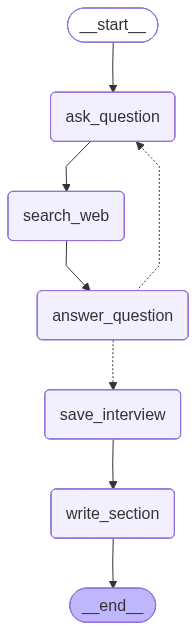

Interview sub-graph compiled successfully


In [8]:
# Build interview sub-graph
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question', 'save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

interview_graph = interview_builder.compile()
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))
print("Interview sub-graph compiled successfully")

## 5. Report Synthesis

In [9]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [10]:
def initiate_all_interviews(state: ResearchGraphState):
    """Initiate parallel interviews with all analysts using Send API."""
    topic = state["topic"]
    return [
        Send("conduct_interview", {
            "analyst": analyst,
            "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")],
            "max_num_turns": 2
        }) for analyst in state["analysts"]
    ]

def write_report(state: ResearchGraphState):
    """Write the main report body from all sections."""
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    
    report = llm.invoke(
        [SystemMessage(content=system_message)] + 
        [HumanMessage(content="Write a report based upon these memos.")]
    )
    
    return {"content": report.content}

def write_introduction(state: ResearchGraphState):
    """Write the report introduction."""
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    
    intro = llm.invoke([instructions] + [HumanMessage(content="Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    """Write the report conclusion."""
    sections = state["sections"]
    topic = state["topic"]
    
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    
    conclusion = llm.invoke([instructions] + [HumanMessage(content="Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """Finalize the complete report."""
    content = state["content"]
    
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    
    sources = None
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            pass
    
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    
    return {"final_report": final_report}

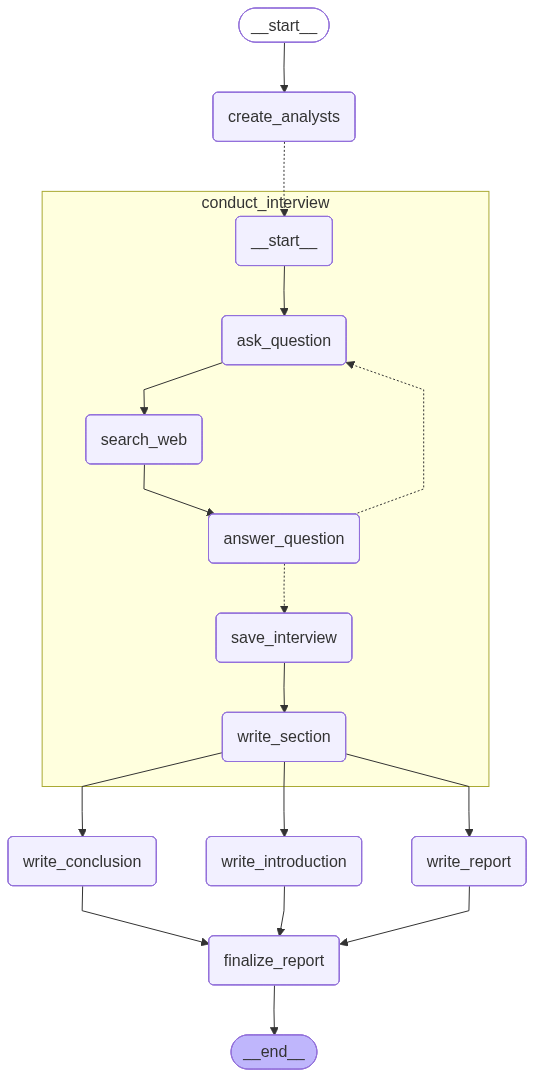

Research graph compiled successfully


In [11]:
# Build main research graph
builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Flow
builder.add_edge(START, "create_analysts")
builder.add_conditional_edges("create_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
research_graph = builder.compile()
display(Image(research_graph.get_graph(xray=1).draw_mermaid_png()))
print("Research graph compiled successfully")

## 6. Agent Wrapper for Evaluation

In [12]:
def baseline_a_agent(inputs: dict) -> dict:
    """
    Wrapper function for the STORM-style research agent.
    
    This function is compatible with the evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key from the evaluation dataset
        
    Returns:
        Dictionary with 'output' key containing the research report
    """
    question = inputs.get("question", "")
    
    # Run the research graph
    result = research_graph.invoke({
        "topic": question,
        "max_analysts": 3
    })
    
    return {
        "output": result.get("final_report", ""),
        "sections": result.get("sections", []),
    }

## 7. Manual Test (Before Harness Evaluation)

Run this cell to verify the agent works correctly with a simple test question.

In [14]:
# Simple test to verify the agent works
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing with question: {test_question}\n")
print("Running research agent (this may take a few minutes)...\n")

try:
    result = baseline_a_agent({"question": test_question})
    print("=" * 80)
    print("RESEARCH REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Number of sections: {len(result.get('sections', []))}")
    print("Agent test PASSED ✓")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    raise

Testing with question: What are the key benefits and challenges of using large language models in enterprise applications?

Running research agent (this may take a few minutes)...

RESEARCH REPORT
# Deploying LLMs in the Enterprise: Benefits, Risks, and Practical Paths to Trust

## Introduction

This report surveys how enterprises can realize LLM benefits—automation, faster knowledge access, and richer customer experiences—while managing new risks. First, we examine operationalizing LLMs at scale: LLMOps, bespoke CI/CD, observability, security trade‑offs, and cost/compute choices for cloud, on‑prem, or hybrid deployments. Second, we outline governance for regulated environments: treating models and datasets as first‑class assets, supply‑chain scrutiny, RBAC, auditability, and controls to limit leakage and comply with residency/IP rules. Finally, we cover RAG‑powered workflows: grounding generation with retrieval, human‑in‑the‑loop patterns, UX for provenance, and measurable KPIs to dri

In [ ]:
from IPython.display import Markdown


## 8. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below to run the full evaluation.

In [13]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

Evaluation harness initialized successfully!
Dataset: ..\data\deep_research_agent_test_dataset.yaml
LangSmith dataset name: deep-research-golden-v2


### 8.1 Dataset Exploration

Before running the evaluation, let's explore the test dataset to understand what we're evaluating against.

In [14]:
# Explore the dataset
questions = harness.load_dataset()

print(f"Total questions in dataset: {len(questions)}\n")

# Count by difficulty
from collections import Counter
difficulties = Counter(q['difficulty'] for q in questions)
print("Questions by difficulty:")
for difficulty, count in difficulties.items():
    print(f"  {difficulty.upper()}: {count} questions")

print("\n" + "="*80)
print("SAMPLE QUESTION (Easy Tier):")
print("="*80)
easy_q = [q for q in questions if q['difficulty'] == 'easy'][0]
print(f"ID: {easy_q['question_id']}")
print(f"Category: {easy_q['category']}")
print(f"\nQuestion:\n{easy_q['question'][:500]}...")
print(f"\nRequired facts: {len(easy_q.get('required_facts', []))}")
print(f"Minimum sources: {easy_q.get('minimum_sources', 0)}")

Total questions in dataset: 20

Questions by difficulty:
  EASY: 5 questions
  MEDIUM: 5 questions
  HARD: 5 questions
  ADVERSARIAL: 5 questions

SAMPLE QUESTION (Easy Tier):
ID: E01
Category: multi_hop_causal_chain

Question:
The global pharmaceutical supply chain experienced significant stress in 2024-2025, 
with persistent drug shortages affecting multiple countries. Analyze the interconnected 
causes of these shortages by examining:

1. The geographic concentration of Active Pharmaceutical Ingredient (API) manufacturing 
   (quantify the shares held by China and India)
2. How geopolitical tensions and trade policies (US-China decoupling, export restrictions) 
   affected specific drug categories
3. The role of cli...

Required facts: 13
Minimum sources: 12


### 8.2 Sync Dataset to LangSmith

**IMPORTANT:** Only run this cell once to upload the test dataset to LangSmith. After the first run, comment it out to avoid duplicate uploads.

In [15]:
# Sync the dataset to LangSmith (only needed once)
# Uncomment the line below to sync:
harness.sync_to_langsmith(overwrite=False)

# If you need to re-sync with fresh data, use overwrite=True:
# harness.sync_to_langsmith(overwrite=True)

print("Dataset sync cell ready. Uncomment to sync when needed.")

Synced 20 examples to LangSmith dataset: deep-research-golden-v2
Dataset sync cell ready. Uncomment to sync when needed.


### 8.3 Option A: Quick Evaluation (Easy Tier Only - Recommended for Testing)

This runs evaluation on just the 5 Easy tier questions. Use this to:
- Validate your agent works correctly with the harness
- Get quick feedback on performance
- Estimate costs before running full evaluation

**Cost estimate:** ~5 questions × 3 runs × 3 analysts × 2 turns = ~90 agent calls + evaluator calls
**Expected runtime:** 15-30 minutes

In [ ]:
# OPTION A: Quick Evaluation on Easy Tier
# Uncomment to run:

# # Create a temporary harness with only Easy questions
# from pathlib import Path
# import yaml
# 
# # Load and filter dataset
# questions_easy = harness.get_questions_by_difficulty("easy")
# print(f"Running quick evaluation on {len(questions_easy)} Easy tier questions\n")
# 
# # Define evaluators (using fast, low-cost evaluators for quick testing)
# evaluators = [
#     fact_recall,              # Checks if required facts are present
#     citation_precision,       # Validates URL citations
#     minimum_sources_check,    # Checks if minimum sources are cited
#     coherence_judge,          # LLM judge for coherence (adds cost)
#     relevance_judge,          # LLM judge for relevance (adds cost)
# ]
# 
# # Run evaluation with Monte Carlo (3 runs per question)
# results = harness.run_evaluation(
#     agent_fn=baseline_a_agent,
#     evaluators=evaluators,
#     experiment_name="baseline_a_quick_test",
#     monte_carlo_runs=3,
#     max_concurrency=2,  # Lower concurrency to avoid rate limits
#     description="Quick evaluation on Easy tier questions for Baseline A"
# )
# 
# # Display results
# print("\n" + "="*80)
# print("QUICK EVALUATION RESULTS")
# print("="*80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Monte Carlo runs: {results.num_runs}")
# print(f"\nAggregated Metrics:")
# for metric_name, value in sorted(results.metrics.items()):
#     print(f"  {metric_name}: {value:.3f}")

print("Quick evaluation cell ready. Uncomment to run.")

### 8.4 Option B: Full Evaluation (All 20 Questions)

This runs the complete evaluation on all 20 questions across all difficulty tiers.

**⚠️ WARNING:** This is expensive and time-consuming!
- **Cost estimate:** ~20 questions × 3 runs × 3 analysts × 2 turns = ~360 agent calls + evaluator calls
- **Expected runtime:** 2-4 hours
- **Estimated cost:** $20-50 depending on API pricing

Only run this when you're ready for a comprehensive evaluation.

In [ ]:
# OPTION B: Full Evaluation on All 20 Questions
# ⚠️ EXPENSIVE - Only uncomment when ready for full evaluation
# Uncomment to run:

# Define comprehensive evaluator suite
evaluators = [
    fact_recall,              # Required facts coverage
    citation_precision,       # Citation URL validity
    minimum_sources_check,    # Minimum source count
    coherence_judge,          # Logical structure
    depth_judge,              # Analysis depth
    relevance_judge,          # Addresses question
]

# Run full evaluation
print("Starting FULL evaluation on all 20 questions...")
print("This will take 2-4 hours and may cost $20-50 in API calls.")
print("="*80 + "\n")

results = harness.run_evaluation(
    agent_fn=baseline_a_agent,
    evaluators=evaluators,
    experiment_name="baseline_a_storm_v1",
    monte_carlo_runs=3,
    max_concurrency=4,
    description="Full evaluation of Baseline A (STORM-style agent) on all difficulty tiers"
)

# Display comprehensive results
print("\n" + "="*80)
print("FULL EVALUATION RESULTS")
print("="*80)
print(f"Experiment: {results.experiment_name}")
print(f"Questions evaluated: {results.num_questions}")
print(f"Monte Carlo runs: {results.num_runs}")

print(f"\n{'Metric':<30} {'Mean':<10} {'Std Dev':<10}")
print("-"*50)
for metric_name in sorted(results.metrics.keys()):
    if metric_name.endswith('_mean'):
        base_name = metric_name[:-5]
        mean_val = results.metrics.get(f"{base_name}_mean", 0)
        std_val = results.metrics.get(f"{base_name}_std", 0)
        print(f"{base_name:<30} {mean_val:<10.3f} {std_val:<10.3f}")

# Save results to file
import json
from datetime import datetime

results_file = Path("../results") / f"baseline_a_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
results_file.parent.mkdir(exist_ok=True)

with open(results_file, 'w') as f:
    json.dump({
        "experiment_name": results.experiment_name,
        "num_questions": results.num_questions,
        "num_runs": results.num_runs,
        "metrics": results.metrics,
        "per_question": results.per_question_results
    }, f, indent=2)

print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")

### 8.5 Viewing Results in LangSmith

After running an evaluation, you can view detailed results in the LangSmith UI:

1. Go to https://smith.langchain.com
2. Navigate to your project (`deep_research_new`)
3. Click on "Datasets" to see your test dataset
4. Click on "Experiments" to see evaluation runs
5. Compare different runs to track improvements

You can also access results programmatically using the code above, which saves results to JSON files in the `results/` directory.